In [39]:
from lib_fetaure_analysis import Features
from defect_analysis import Test
from pathlib import Path
from matplotlib import pyplot as plt
from matplotlib import image as mpimg
import torch as Torch
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from ultralytics import YOLO
from lib.lib_utils import Utils 
import seaborn as sns
import seaborn.objects as so


## Generazione immagini da .xyz 

In [ ]:
#trasformazione .xyz to .png 
Utils.from_xyz_to_png(
    Path('/home/gabro/GrapheDetectProject/data.xyz/subset_xyz'), 
    Path('/home/gabro/GrapheDetectProject/immPerInferenza'), 
    2000)

## Inferenza yolo e crop difetti

In [ ]:
# Load a model
# model = YOLO("yolov8n.yaml")  # build a new model from scratch
model = YOLO("/home/gabro/GrapheDetectProject/best_100_campioni_new.pt")  # load a pretrained model (recommended for training)
#fa l'inferenza su una cartella di campioni con yolo salvandone le box su un'altra cartella
Utils.crop_from_folder("/home/gabro/GrapheDetectProject/immPerInferenza", "/home/gabro/GrapheDetectProject/cartellaCrop", model)

## Evidenzia i difetti 

In [ ]:
#per ogni crop in carttelaCrop/ ne produce una copia su cartellaTrash/ in cui ne si enfatizza l'area
Utils.from_crops_to_thresh('/home/gabro/GrapheDetectProject/cartellaCrop/', '/home/gabro/GrapheDetectProject/cartellaTrash')

## Produzione contonri, calcolo features e creazione dataframe 

ERRORE: Non sono stati trovati contorni in: 
/home/gabro/GrapheDetectProject/cartellaTrash/graphene_82166_bonds_cropped_box_1_thresh_.png
Vengono assunti 0 i parametri.
ERRORE: Non sono stati trovati contorni in: 
/home/gabro/GrapheDetectProject/cartellaTrash/graphene_179283_bonds_cropped_box_2_thresh_.png
Vengono assunti 0 i parametri.
ERRORE: Non sono stati trovati contorni in: 
/home/gabro/GrapheDetectProject/cartellaTrash/graphene_136424_bonds_cropped_box_3_thresh_.png
Vengono assunti 0 i parametri.
ERRORE: Non sono stati trovati contorni in: 
/home/gabro/GrapheDetectProject/cartellaTrash/graphene_111963_bonds_cropped_box_1_thresh_.png
Vengono assunti 0 i parametri.
old df
             nome_imm  numero_atomi  area_px  num_pixels  perimeter_px   
0      graphene_91559           316    148.0         304     60.195017  \
1      graphene_74004           392    517.5        1155    106.356822   
2      graphene_51150           388    551.5        1188     90.124483   
3      graphene_59

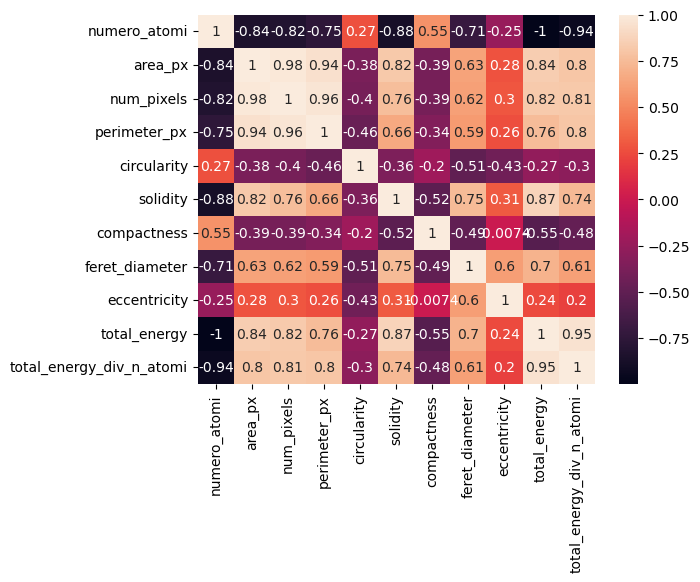

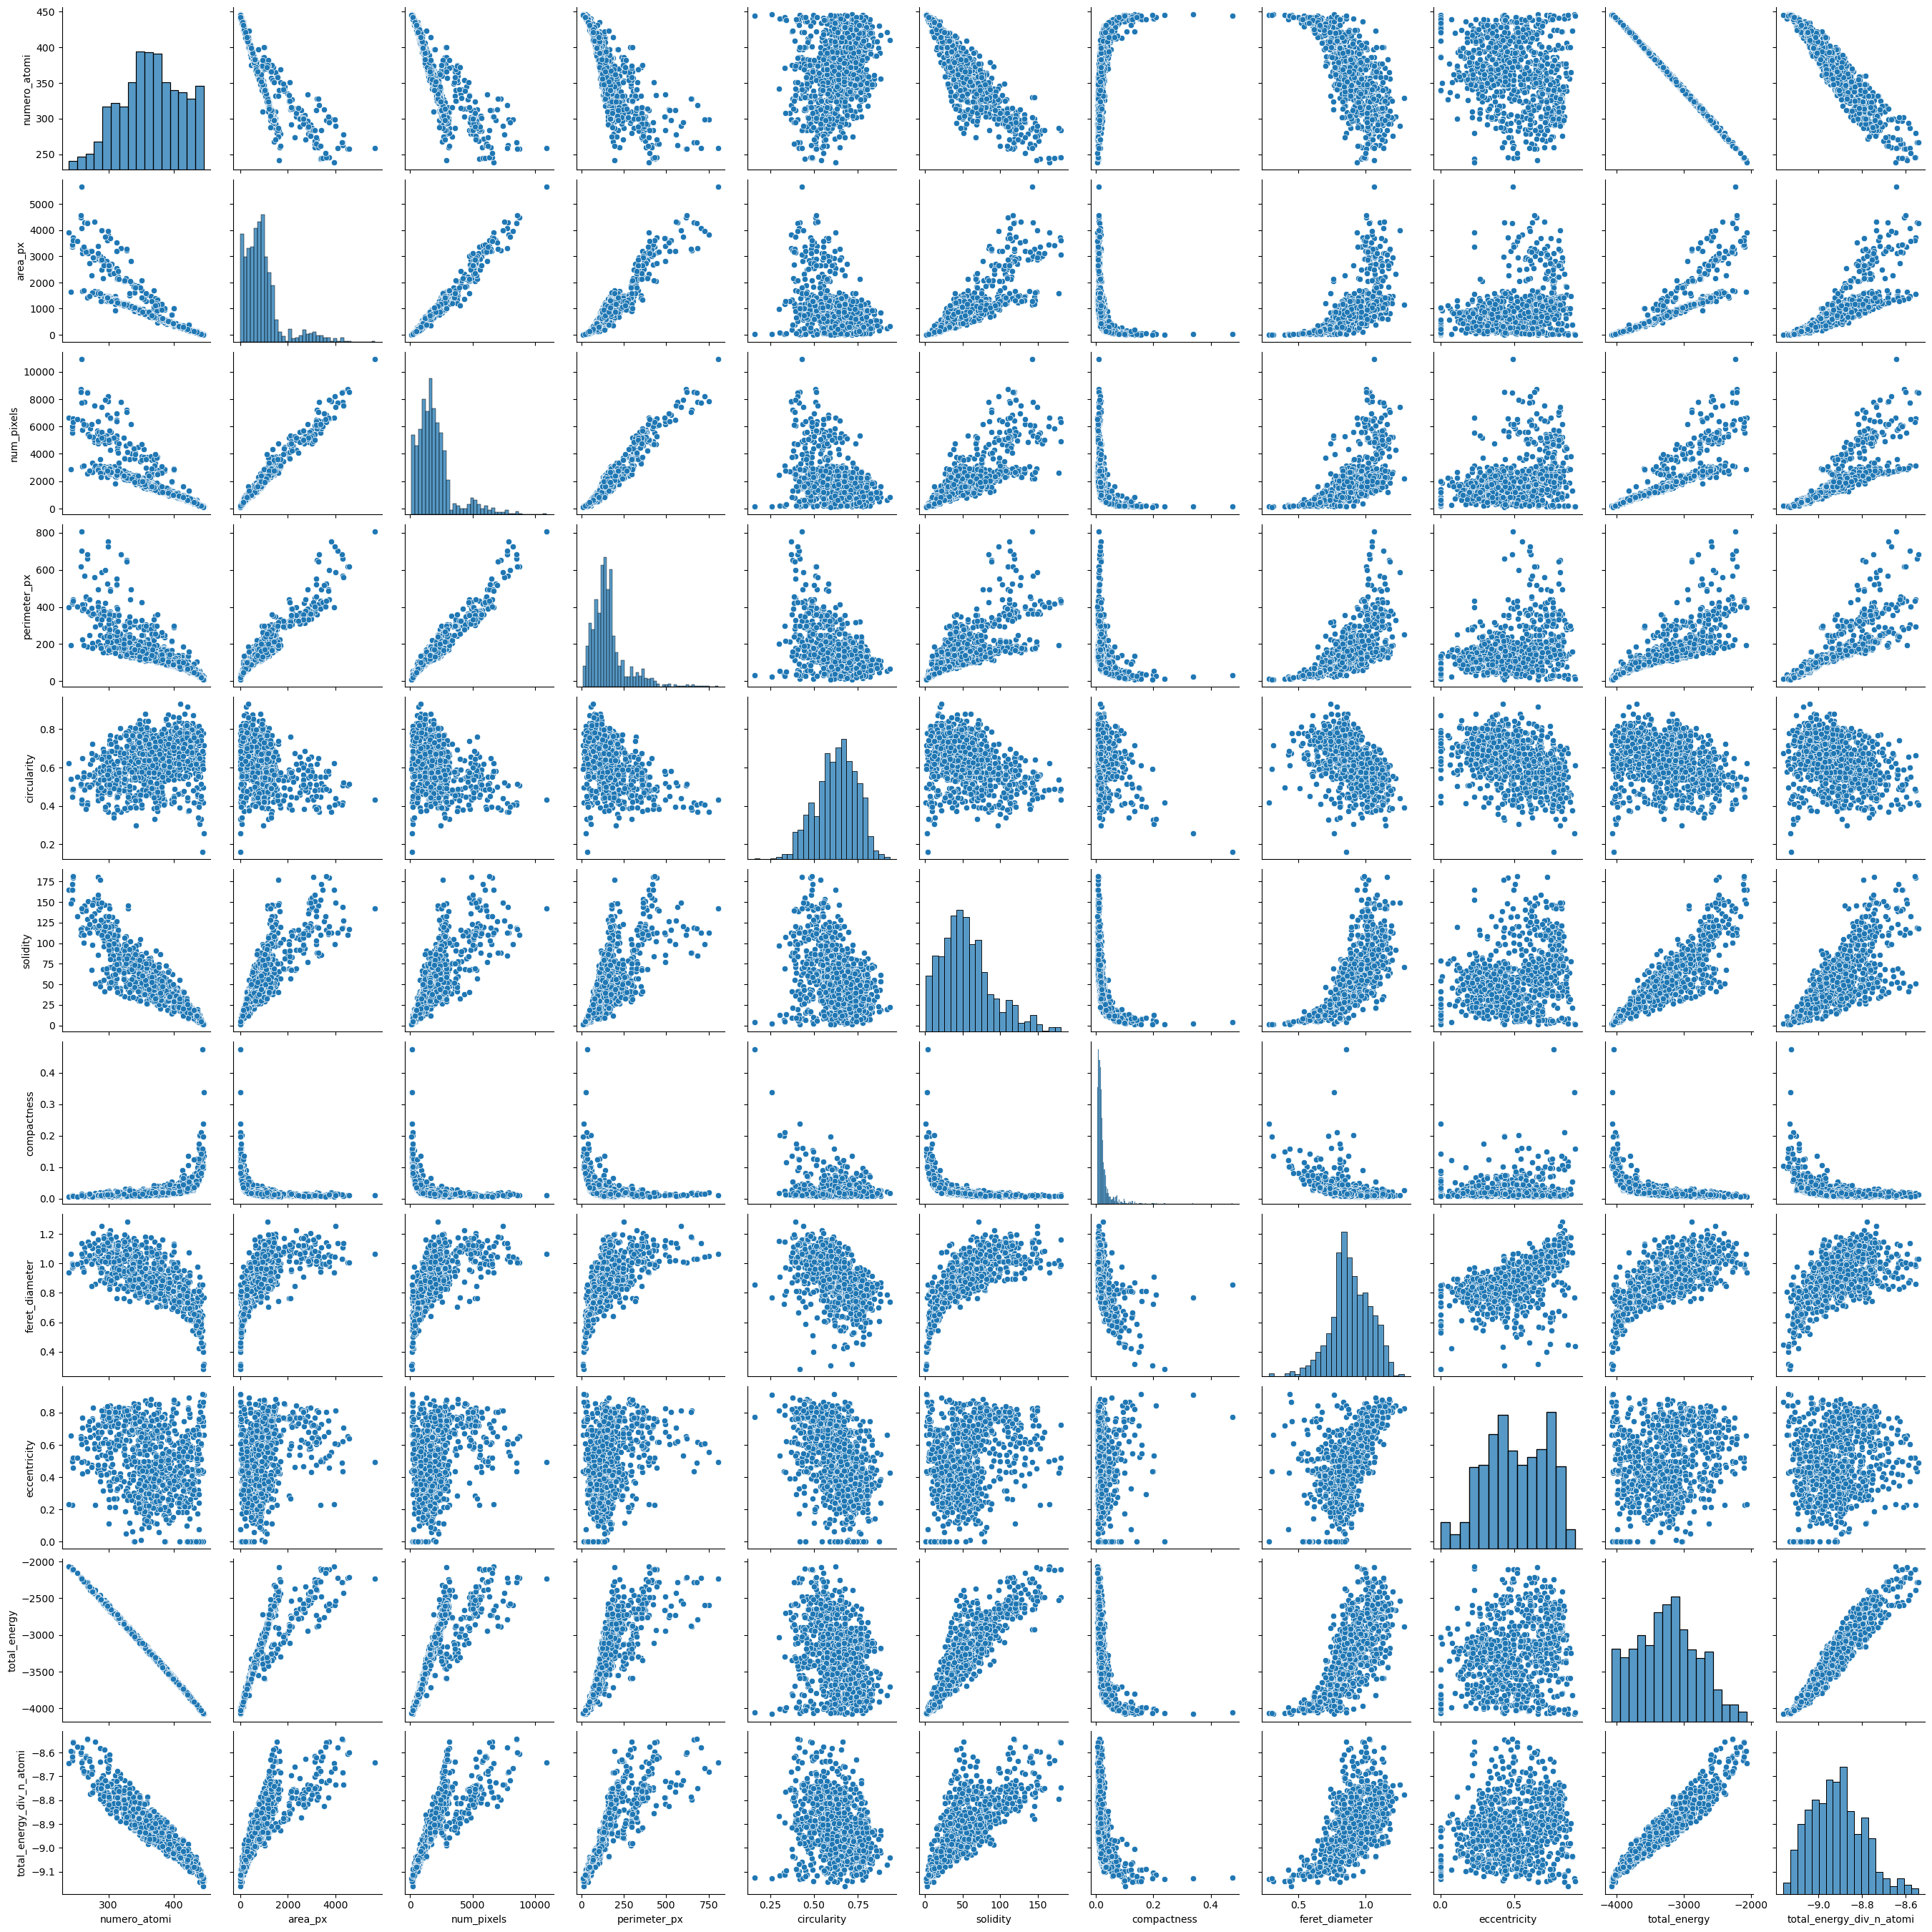

In [2]:
pathCartellaTresh = Path('/home/gabro/GrapheDetectProject/cartellaTrash')
pathCartellaContours = Path('/home/gabro/GrapheDetectProject/contours')
shapes = Features.from_thresh_to_contours_print_features(pathCartellaTresh,pathCartellaContours)
# for shape in shapes:
#     print("Shape features:")
#     for key in shape:
#         print(key, ' : ', shape[key])
#     print()

boxes_df = pd.DataFrame.from_records(shapes)
boxes_df.to_csv('/home/gabro/GrapheDetectProject/dataframes/box_dataframe.csv')
print("old df")
print(boxes_df)

# raggruppa le righe in base al nome dell'immagine e calcola la somma dell'area e del perimetro, e la media pesata per l'area degli altri parametri
grouped_df = boxes_df.groupby('nome_imm').apply(lambda x: pd.Series({
    "numero_atomi": x['numero_atomi'].max(),    #notare come i due volori del numero di atomi sono guali, scelgo il massimo solo per sceglierne uno a caso.
    'area_px': x['area_px'].sum(),  #somma semplice per area e perimetro 
    # 'area_px_div_n_atomi': x['area_px_div_n_atomi'].sum(), 
    'num_pixels': x['num_pixels'].sum(),
    'perimeter_px': x['perimeter_px'].sum(),
    # 'perimeter_px_div_n_atomi': x['perimeter_px_div_n_atomi'].sum(), 
    'circularity': (x['circularity'] * x['area_px']).sum() / x['area_px'].sum(),    #somma pesata per l'area per tutti gli altri 
    'solidity': (x['solidity'] * x['area_px']).sum() / x['area_px'].sum(),
    'compactness': (x['compactness'] * x['area_px']).sum() / x['area_px'].sum(),
    'feret_diameter': (x['feret_diameter'] * x['area_px']).sum() / x['area_px'].sum(),
    'eccentricity': (x['eccentricity'] * x['area_px']).sum() / x['area_px'].sum(),
}))
grouped_df.to_csv('/home/gabro/GrapheDetectProject/dataframes/groupedDataframe.csv')
print("-----------------------------------------------------------------------------")
print("grouped dataframe")
# print(groupedDf)

# aggiungo total_energy facebdo il merge dal dataset dataset_graphene.csv
total_energy_dataset_df = pd.read_csv("/home/gabro/GrapheDetectProject/dataframes/dataset_graphene.csv")

merged_df = grouped_df.merge(total_energy_dataset_df[['file_name', 'total_energy']], left_on='nome_imm', right_on='file_name')
merged_df = merged_df.drop('file_name', axis=1)

merged_df = merged_df.assign(total_energy_div_n_atomi=merged_df["total_energy"] / merged_df["numero_atomi"])

# salvo e stampo il dataframe finale  
merged_df.to_csv('/home/gabro/GrapheDetectProject/dataframes/energy_dataframe.csv')
print(merged_df)

# stampo heatmap 
corr = merged_df.corr()
sns.heatmap(corr, annot=True)

# stampo basic correlogram
sns.pairplot(merged_df)
plt.show()


## Predittore total_energy

In [90]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import ensemble
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


## Prendo i dati dal dataframe Pandas e li converto nel giusto formato

In [100]:
# dataRegression = merged_df[["numero_atomi" , "area_px"]].values #una colonna per ogni feature, una riga per ogni campione 
featuresList = [ "area_px", "num_pixels", "circularity", "solidity", "compactness", "feret_diameter", "eccentricity"]
# featuresList = [ "area_px", "circularity", "solidity", "compactness", "feret_diameter", "eccentricity"]
# featuresList = [ "area_px"]
dataRegression = merged_df[[ "area_px", "num_pixels", "circularity", "solidity", "compactness", "feret_diameter", "eccentricity"]].values
# dataRegression = merged_df[["area_px", "circularity", "solidity", "compactness", "feret_diameter", "eccentricity"]].values
# dataRegression = merged_df[[ "area_px"]].values

targetRegression = merged_df["total_energy"].values.flatten() #array con tutti i valori raget total_energy
targetRegression

X = dataRegression
y = targetRegression

print(X.shape)
print(y.shape)

#creo una copia dei dati normalizzata 
scaler = MinMaxScaler()
X_norm = scaler.fit_transform(X)

scaler2 = MinMaxScaler()
y_norm = scaler2.fit_transform(y.reshape(-1, 1))


featuresList

(991, 7)
(991,)
[[         72         416     0.81423 ...    0.073643      0.5224     0.50653]
 [        923        2085     0.78132 ...    0.011691     0.77899     0.18348]
 [     1326.5        2663     0.60386 ...    0.023841     0.91593     0.42462]
 ...
 [       1042        1923     0.54957 ...    0.015372      1.1273     0.76825]
 [      132.5         462     0.75839 ...    0.035865     0.65785     0.32015]
 [       1122        3954     0.64416 ...    0.018846     0.76918     0.58564]]
---------------------


['area_px',
 'num_pixels',
 'circularity',
 'solidity',
 'compactness',
 'feret_diameter',
 'eccentricity']

## Splitto il dataset e faccio tuning degli hyperparametri

In [110]:
X_train, X_test, y_train, y_test = train_test_split(
    # X_norm, y_norm, test_size=0.1, random_state=13
    X, y, test_size=0.1, random_state=13
)

params = {
    "n_estimators": 500,
    "max_depth": 20,
    "min_samples_split": 5,
    "learning_rate": 0.01,
    "loss": "squared_error",
}


## Scelgo il regressore e la funzione di costo

In [111]:
reg = ensemble.GradientBoostingRegressor(**params)
reg.fit(X_train, y_train)

mse = mean_squared_error(y_test, reg.predict(X_test))
print("The mean squared error (MSE) on test set: {:.4f}".format(mse))

The mean squared error (MSE) on test set: 6910.6088


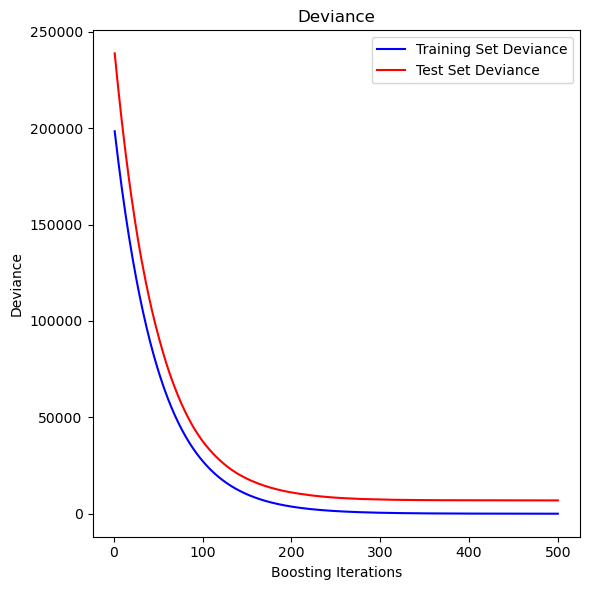

In [112]:
test_score = np.zeros((params["n_estimators"],), dtype=np.float64)
for i, y_pred in enumerate(reg.staged_predict(X_test)):
    test_score[i] = mean_squared_error(y_test, y_pred)

fig = plt.figure(figsize=(6, 6))
plt.subplot(1, 1, 1)
plt.title("Deviance")
plt.plot(
    np.arange(params["n_estimators"]) + 1,
    reg.train_score_,
    "b-",
    label="Training Set Deviance",
)
plt.plot(
    np.arange(params["n_estimators"]) + 1, test_score, "r-", label="Test Set Deviance"
)
plt.legend(loc="upper right")
plt.xlabel("Boosting Iterations")
plt.ylabel("Deviance")
fig.tight_layout()
plt.show()

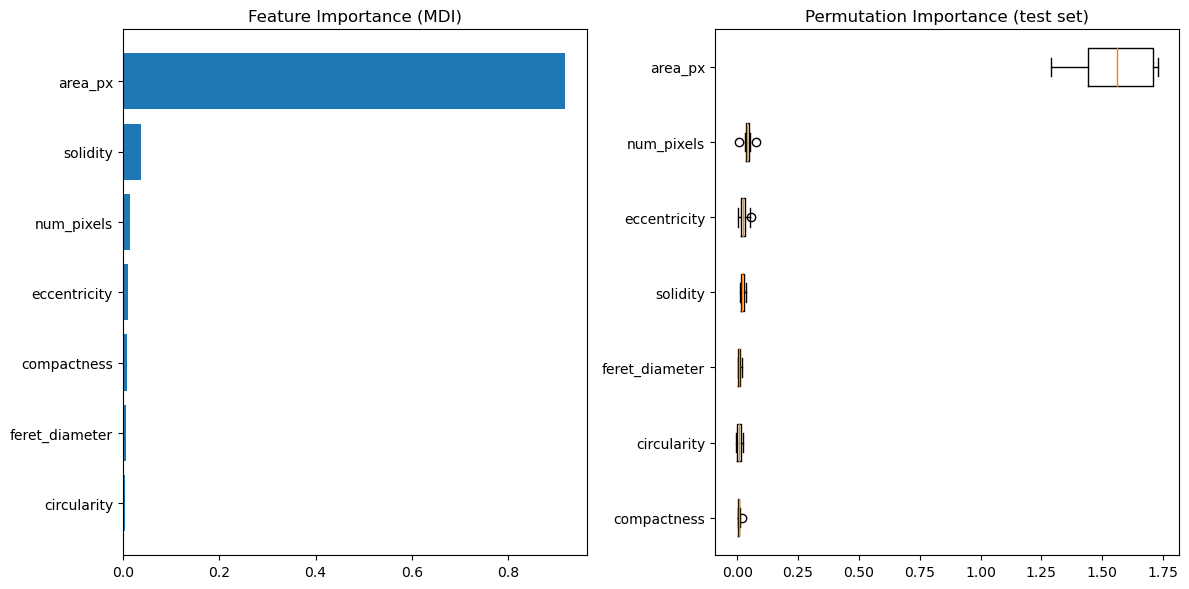

In [113]:
feature_importance = reg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + 0.5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align="center")
plt.yticks(pos, np.array(featuresList)[sorted_idx])
plt.title("Feature Importance (MDI)")

result = permutation_importance(
    reg, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(
    result.importances[sorted_idx].T,
    vert=False,
    labels=np.array(featuresList)[sorted_idx],
)
plt.title("Permutation Importance (test set)")
fig.tight_layout()  
plt.show()

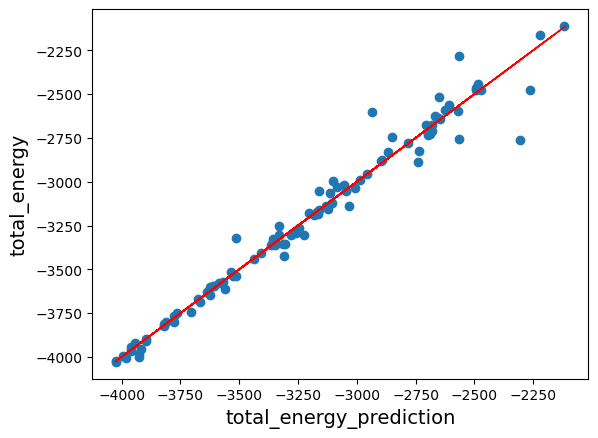

In [124]:
plt.scatter(y_pred, y_test)
# plt.scatter(y_test, y_pred)
plt.plot(y_test, y_test,  color='red', linewidth=1)

plt.xlabel("total_energy_prediction", fontsize=14)
plt.ylabel("total_energy", fontsize = 14)
plt.show()


# Predizioni e confronto con valori target

In [115]:
print("Target total_energy: ")
print(y_test[1:10])
print("Predicted total_energy: ")
print(reg.predict(X_test[1:10]))
print("Error: ")
print(y_test[1:10]-reg.predict(X_test[1:10]))


Target total_energy: 
[    -2678.2       -3966     -3359.6     -2743.9     -3354.6     -3156.8     -3305.2     -2644.6     -3136.1]
Predicted total_energy: 
[    -2681.7     -3962.1     -3346.8       -2852     -3312.4     -3124.6     -3281.6     -2644.5     -3033.4]
Error: 
[     3.5572     -3.8752     -12.796      108.06     -42.136     -32.134      -23.56    -0.11962     -102.68]


# R^2 score 

In [116]:
reg.score(X_test, y_test)

0.9715347951161298

In [117]:
reg.staged_predict(X)

<generator object GradientBoostingRegressor.staged_predict at 0x7f0cea3d8ac0>